# Exercise 8: Anomaly Detection and Recommender Systems

In this exercise, has two major parts:
1. Anomaly detection to detect failing servers on a network.
2. Recommender system based on collaborative filtering to predict a movie ratings.

Files provided by Coursera, located under `../exercises/ex1-ex8-octave/ex8`

- `ex8.m` - Octave/MATLAB script for first part of exercise
- `ex8_cofi.m` - Octave/MATLAB script for second part of exercise
- `ex8data1.mat` - First example Dataset for anomaly detection
- `ex8data2.mat` - Second example Dataset for anomaly detection
- `ex8_movies.mat` - Movie Review Dataset
- `ex8_movieParams.mat` - Parameters provided for debugging
- `multivariateGaussian.m` - Computes the probability density function for a Gaussian distribution
- `visualizeFit.m` - 2D plot of a Gaussian distribution and a dataset
- `checkCostFunction.m` - Gradient checking for collaborative filtering
- `computeNumericalGradient.m` - Numerically compute gradients
- `fmincg.m` - Function minimization routine (similar to fminunc)
- `loadMovieList.m` - Loads the list of movies into a cell-array
- `movie_ids.txt` - List of movies
- `normalizeRatings.m` - Mean normalization for collaborative filtering
- `submit.m` - Submission script that sends your solutions to our servers

Files to complete:

- `estimateGaussian.m` - Estimate the parameters of a Gaussian ditribution with a diagonal covariance matrix
- `selectThreshold.m` - Find a threshold for anomaly detection
- `cofiCostFunc.m` - Implement the cost function for collaborative filtering

Workflow:

- Download latest Octave version of exercise from Coursera
- Complete code in exercise files following `ex8.pdf`
- Whenever an exercise part is finished
  - Check it with `ex8` and `ex8_cofi` in Octave terminal
  - Create a submission token on Coursera (exercise submission page, it lasts 30 minutes)
  - Execute `submit` in Octave terminal
  - Introduce email and token
  - Results appear

**Overview of contents:**

0. Setup: `gnuplot`
1. Dataset Loading & Visualization
2. Anomaly Detection - `ex8.m`
    - 2.1 Gaussian Distribution: Parameters - `estimateGaussian.m`
    - 2.2 Selecting the Threshold `epsilon` - `selectThreshold.m`
3. Recommender Systems - `ex8_cofi.m`
   - 3.1 Collaborative Filtering - `cofiCostFunc.m`
     - 3.1.1 Cost Function without Regularization
     - 3.1.2 Cost Function Gradient without Regularization
     - 3.1.3 Cost Function with Regularization
     - 3.1.4 Cost Function Gradient with Regularization
   - 3.2 Train and Test the Model (Ungraded, Taken from `ex_cofi.m`)
     - Set Ratings
     - Load Data & Optimize Model Parameters
     - Estimate Ratings with Model

## 0. Setup: `gnuplot`

In [5]:
graphics_toolkit ("gnuplot");

In [6]:
%plot -b inline:gnuplot

## 1. Dataset Loading & Visualization

In [10]:
% Load the dataset
clear all;
load('ex8data1.mat');

In [13]:
who

Variables visible from the current scope:

X     Xval  yval



In [15]:
% Features: throughput (MB/s), latency (ms)
% m = 307 exammples
size(X)

ans =

   307     2



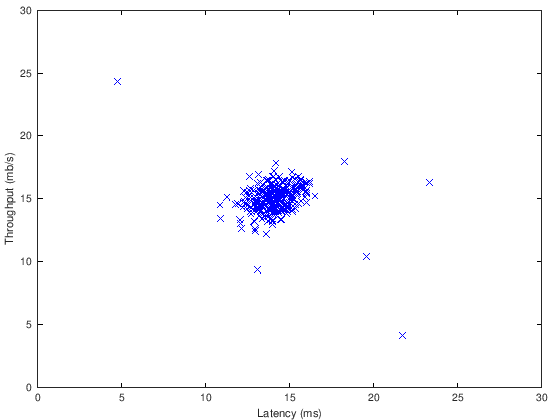

In [16]:
% Visualize the example dataset
plot(X(:, 1), X(:, 2), 'bx');
axis([0 30 0 30]);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');

## 2. Anomaly Detection - `ex8.m`

### 2.1 Gaussian Distribution: Parameters - `estimateGaussian.m`

$$\{x^{(1)}, \dots, x^{(j)}, \dots, x^{(m)} \}, \,\,\, x^{(j)} \in \mathbb{R}^n, \,\,\, j = 1 \dots m$$

$$x^{(j)} = [x^{(j)}_1, \dots, x^{(j)}_i, \dots, x^{(j)}_n]^T, \,\,\, i = 1 \dots n$$

$$\mu_i, \,\,\, \sigma_i^2$$

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$

In [24]:
function [mu sigma2] = estimateGaussian_(X)
    % [mu sigma2] = estimateGaussian(X), 
    % The input X is the dataset with each n-dimensional data point in one row
    % The output is an n-dimensional vector mu, the mean of the data set
    % and the variances sigma^2, an n x 1 vector

    % Useful variables
    [m, n] = size(X);

    % You should return these values correctly
    mu = zeros(n, 1);
    sigma2 = zeros(n, 1);

    mu = mean(X)';
    sigma2 = var(X,1)'; % normalize using (m-1) instead of m
end

In [25]:
%  Estimate my and sigma2
[mu sigma2] = estimateGaussian_(X);

In [26]:
mu

mu =

   14.112
   14.998



In [27]:
sigma2

sigma2 =

   1.8326
   1.7097



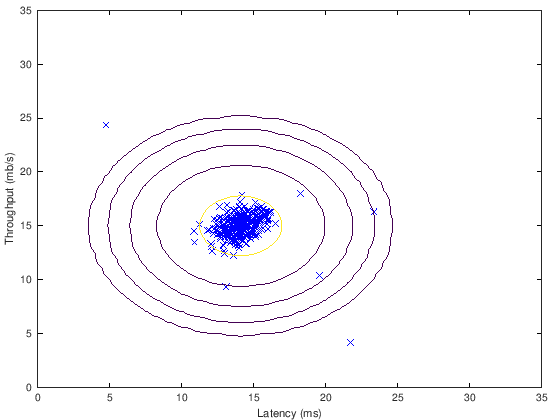

In [28]:
%  Visualize the fit
visualizeFit(X,  mu, sigma2);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');

### 2.2 Selecting the Threshold `epsilon` - `selectThreshold.m`

In [49]:
function [bestEpsilon bestF1] = selectThreshold_(yval, pval)
    % [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
    % threshold to use for selecting outliers based on the results from a
    % validation set (pval) and the ground truth (yval).

    bestEpsilon = 0;
    bestF1 = 0;
    F1 = 0;

    stepsize = (max(pval) - min(pval)) / 1000;
    for epsilon = min(pval):stepsize:max(pval)
    
        cvPredictions = (pval < epsilon); % 1 if anomaly: p < epsilon!

        tp = sum((cvPredictions == yval) & (yval == 1));
        tn = sum((cvPredictions == yval) & (yval == 0));
        fp = sum((cvPredictions != yval) & (yval == 0));
        fn = sum((cvPredictions != yval) & (yval == 1));

        precision = tp / (tp + fp);
        recall = tp / (tp + fn);
        F1 = 2*precision*recall / (precision+recall);

        if F1 > bestF1
           bestF1 = F1;
           bestEpsilon = epsilon;
        end
    end

end

In [54]:
% Provided in the course
% Since sigma2 is a vector, Sigma is constructed as a diagonal matrix
% thus, the multivariate Gaussian is equivalent to the univariate!
% For more info, look in the code :)
pval = multivariateGaussian(Xval, mu, sigma2);

In [58]:
[epsilon F1] = selectThreshold_(yval, pval)

epsilon = 8.9909e-05
F1 = 0.8750


In [59]:
% Compute the model (again)
[mu sigma2] = estimateGaussian(X);
p = multivariateGaussian(X, mu, sigma2);

In [84]:
% Find the outliers in the training set and plot the
outliers = find(p < epsilon);
%outliers = find(p < 1.5e-2);

In [85]:
% Outliers found
length(outliers)

ans = 6


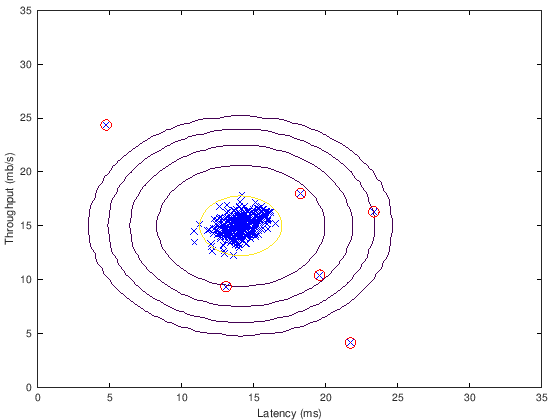

In [86]:
% Plot the ooutliers
visualizeFit(X,  mu, sigma2);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');
hold on;
plot(X(outliers, 1), X(outliers, 2), 'ro', 'LineWidth', 2, 'MarkerSize', 10);
hold off;

## 3. Recommender Systems - `ex8_cofi.m`

Dataset: [MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/).

In [87]:
% Load data
clear all;
load ('ex8_movies.mat');

In [88]:
who

Variables visible from the current scope:

R  Y



In [90]:
% Y is a 1682x943 matrix: ratings (1-5) of 1682 movies on 943 users
size(Y)
% R is a 1682x943 matrix: R(i,j) = 1 iff user j gave a rating to movie i
size(R)

ans =

   1682    943

ans =

   1682    943



In [93]:
% Average rating of the first movie
mean(Y(1, R(1, :)))

ans = 3.8783


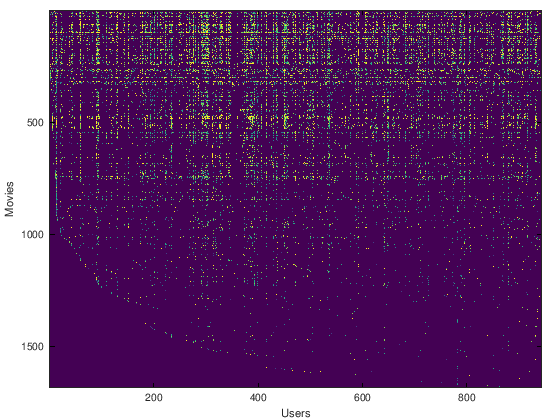

In [94]:
% We can "visualize" the ratings matrix by plotting it with imagesc
imagesc(Y);
ylabel('Movies');
xlabel('Users');

In [128]:
% We factorize Y to X and Theta:
% X: movie features: num_movies x n
% Theta: user weights for movie features: num_users x n
% Y: num_movies x num_users: ratings
% R: num_movies x num_users: R(i,j) = 1 if there is a rating in Y, 0 otherwise
% n: number of features -> chosen to be 100
% i: movie counter: 1:num_movies
% j: user counter: 1:num_users

$$ \text{X} = 
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{Theta} = 
\begin{bmatrix}
- \left(\theta^{(1)}\right)^T - \\
- \left(\theta^{(2)}\right)^T - \\
\vdots \\
- \left(\theta^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

### 3.1 Collaborative Filtering - `cofiCostFunc.m`

#### 3.1.1 Cost Function without Regularization

$$
J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

In [130]:
function [J, grad] = cofiCostFunc_(params, Y, R, num_users, num_movies, ...
                                   num_features, lambda)
    % [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    % num_features, lambda) returns the cost and gradient for the
    % collaborative filtering problem.

    % Unfold the U and W matrices from params
    X = reshape(params(1:num_movies*num_features), num_movies, num_features);
    Theta = reshape(params(num_movies*num_features+1:end), num_users, num_features);

    % You need to return the following values correctly
    J = 0;
    X_grad = zeros(size(X));
    Theta_grad = zeros(size(Theta));

    % We factorize Y to X and Theta:
    % X: movie features: num_movies x n
    % Theta: user weights for movie features: num_users x n
    % Y: num_movies x num_users: ratings
    % R: num_movies x num_users: R(i,j) = 1 if there is a rating in Y, 0 otherwise
    % n: number of features -> chosen to be 100
    % i: movie counter: 1:num_movies
    % j: user counter: 1:num_users
    
    Y_hat = X*Theta';
    % Option 1
    %D = Y_hat(R==1) - Y(R==1);
    %J = (1.0/2.0) * D'*D;
    % Option 2
    D = Y_hat.*R - Y.*R;
    J = (1.0/2.0) * sum(sum(D.*D));
    
    % X_grad: num_movies x n: dJ/dX, all elements of X
    % Theta_grad: num_users x n: dJ/dTheta, all elements of Theta
    
    % Pack the results: unroll!
    grad = [X_grad(:); Theta_grad(:)];

end

In [131]:
% Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
load ('ex8_movieParams.mat');

In [132]:
% Reduce the data set size so that this runs faster
num_users = 4; num_movies = 5; num_features = 3;
X = X(1:num_movies, 1:num_features);
Theta = Theta(1:num_users, 1:num_features);
Y = Y(1:num_movies, 1:num_users);
R = R(1:num_movies, 1:num_users);

In [133]:
% Evaluate cost function
J = cofiCostFunc_([X(:) ; Theta(:)], Y, R, num_users, num_movies, num_features, 0)

J = 22.225


#### 3.1.2 Cost Function Gradient without Regularization

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(i)} $$

Note that:
- $k = 1 \dots n$ (features)
- $x_k^{(i)}$: row $i$ and column $k$, i.e., movie $i$ and feature $k$
- $\theta_k^{(j)}$: row $j$ and column $k$, i.e., user $j$ and feature $k$
- $j:r(i,j)=1$: over all $j$ values where $r(i,j)=1$

See the notes on the gradient computation in the exercise guide and in the following file:

`../../../07_Anomaly_Recommender/RecommenderSystems_Notes.pdf`

In [138]:
function [J, grad] = cofiCostFunc_(params, Y, R, num_users, num_movies, ...
                                   num_features, lambda)
    % [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    % num_features, lambda) returns the cost and gradient for the
    % collaborative filtering problem.

    % Unfold the U and W matrices from params
    X = reshape(params(1:num_movies*num_features), num_movies, num_features);
    Theta = reshape(params(num_movies*num_features+1:end), num_users, num_features);

    % You need to return the following values correctly
    J = 0;
    X_grad = zeros(size(X));
    Theta_grad = zeros(size(Theta));

    % We factorize Y to X and Theta:
    % X: movie features: num_movies x n
    % Theta: user weights for movie features: num_users x n
    % Y: num_movies x num_users: ratings
    % R: num_movies x num_users: R(i,j) = 1 if there is a rating in Y, 0 otherwise
    % n: number of features -> chosen to be 100
    % i: movie counter: 1:num_movies
    % j: user counter: 1:num_users

    Y_hat = X*Theta';
    % Option 1
    %D = Y_hat(R==1) - Y(R==1);
    %J = (1.0/2.0) * D'*D;
    % Option 2
    D = Y_hat.*R - Y.*R;
    J = (1.0/2.0) * sum(sum(D.*D));

    % X_grad: num_movies x n: dJ/dX, all elements of X
    % Theta_grad: num_users x n: dJ/dTheta, all elements of Theta
    
    % Notes on notation:
    % k = 1:n (features), num_features
    % x_k^{(i)}: row i and column k, i.e., movie i and feature k
    % theta_k^{(j)}: row j and column k, i.e., user j and feature k
    % j:r(i,j)=1: over all j values where r(i,j)=1
    
    # Gradients: dJ/dX, dJ/dTheta
    for i=1:num_movies
        idx = find(R(i,:)==1); % users that have rated movie i
        Theta_tmp = Theta(idx,:); % |idx:users-i| x n
        Y_tmp = Y(i,idx); % 1 x |idx:users-i|
        % (1 x n) x (n x |idx:users-i|) x (|idx:users-i| x n) = 1 x n
        X_grad(i,:) = (X(i,:)*Theta_tmp'-Y_tmp)*Theta_tmp;
    end

    for j=1:num_users
        idx = find(R(:,j)==1); % movies that user j has rated
        X_tmp = X(idx,:); % |idx:movies-j| x n
        Y_tmp = Y(idx,j); % |idx:movies-j| x 1
        % (|idx:movies-j| x n) x (n x 1) = |idx:movies-j| x 1 -> 1 x |idx:movies-j|
        Theta_grad(j,:) = (X_tmp*Theta(j,:)'-Y_tmp)'*X_tmp;
    end

    % Pack the results: unroll!
    grad = [X_grad(:); Theta_grad(:)];

end

In [137]:
% File provided in the exercise: check the cost function
checkCostFunction

   9.8753e+00   9.8753e+00
   6.4936e-01   6.4936e-01
  -2.7941e+00  -2.7941e+00
  -5.6604e-01  -5.6604e-01
   5.7252e+00   5.7252e+00
  -7.6492e+00  -7.6492e+00
   3.3833e+00   3.3833e+00
   9.9022e-01   9.9022e-01
  -8.1562e-01  -8.1562e-01
   3.5537e+00   3.5537e+00
  -3.2401e+00  -3.2401e+00
  -3.2753e-01  -3.2753e-01
   6.4555e-01   6.4555e-01
   8.1364e+00   8.1364e+00
  -3.2778e-02  -3.2778e-02
  -1.1391e+01  -1.1391e+01
   3.1345e+00   3.1345e+00
  -4.4051e+00  -4.4051e+00
   5.0451e+00   5.0451e+00
   2.4509e-01   2.4509e-01
  -7.6408e+00  -7.6408e+00
   2.0207e+00   2.0207e+00
   9.7992e+00   9.7992e+00
  -8.5741e-01  -8.5741e-01
   2.8312e-01   2.8312e-01
  -1.3509e+01  -1.3509e+01
   3.3984e+00   3.3984e+00
The above two columns you get should be very similar.
(Left-Your Numerical Gradient, Right-Analytical Gradient)

If your cost function implementation is correct, then 
the relative difference will be small (less than 1e-9). 

Relative Difference: 1.28068e-12


#### 3.1.3 Cost Function with Regularization

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

In [141]:
function [J, grad] = cofiCostFunc_(params, Y, R, num_users, num_movies, ...
                                   num_features, lambda)
    % [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    % num_features, lambda) returns the cost and gradient for the
    % collaborative filtering problem.

    % Unfold the U and W matrices from params
    X = reshape(params(1:num_movies*num_features), num_movies, num_features);
    Theta = reshape(params(num_movies*num_features+1:end), num_users, num_features);

    % You need to return the following values correctly
    J = 0;
    X_grad = zeros(size(X));
    Theta_grad = zeros(size(Theta));

    % We factorize Y to X and Theta:
    % X: movie features: num_movies x n
    % Theta: user weights for movie features: num_users x n
    % Y: num_movies x num_users: ratings
    % R: num_movies x num_users: R(i,j) = 1 if there is a rating in Y, 0 otherwise
    % n: number of features -> chosen to be 100
    % i: movie counter: 1:num_movies
    % j: user counter: 1:num_users

    Y_hat = X*Theta';
    % Option 1
    %D = Y_hat(R==1) - Y(R==1);
    %J = (1.0/2.0) * D'*D;
    % Option 2
    D = Y_hat.*R - Y.*R;
    J = (1.0/2.0) * sum(sum(D.*D));

    % X_grad: num_movies x n: dJ/dX, all elements of X
    % Theta_grad: num_users x n: dJ/dTheta, all elements of Theta
    
    % Notes on notation:
    % k = 1:n (features), num_features
    % x_k^{(i)}: row i and column k, i.e., movie i and feature k
    % theta_k^{(j)}: row j and column k, i.e., user j and feature k
    % j:r(i,j)=1: over all j values where r(i,j)=1
    
    # Gradients: dJ/dX, dJ/dTheta
    for i=1:num_movies
        idx = find(R(i,:)==1); % users that have rated movie i
        Theta_tmp = Theta(idx,:); % |idx:users-i| x n
        Y_tmp = Y(i,idx); % 1 x |idx:users-i|
        % (1 x n) x (n x |idx:users-i|) x (|idx:users-i| x n) = 1 x n
        X_grad(i,:) = (X(i,:)*Theta_tmp'-Y_tmp)*Theta_tmp;
    end

    for j=1:num_users
        idx = find(R(:,j)==1); % movies that user j has rated
        X_tmp = X(idx,:); % |idx:movies-j| x n
        Y_tmp = Y(idx,j); % |idx:movies-j| x 1
        % (|idx:movies-j| x n) x (n x 1) = |idx:movies-j| x 1 -> 1 x |idx:movies-j|
        Theta_grad(j,:) = (X_tmp*Theta(j,:)'-Y_tmp)'*X_tmp;
    end
    
    % Cost Regularization
    X_reg = 0.5*lambda*sum(sum(X.*X));
    Theta_reg = 0.5*lambda*sum(sum(Theta.*Theta));
    J = J + X_reg + Theta_reg;

    % Pack the results: unroll!
    grad = [X_grad(:); Theta_grad(:)];

end

#### 3.1.4 Cost Function Gradient with Regularization

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(i)} + \lambda \theta_k^{(j)} $$

In [143]:
function [J, grad] = cofiCostFunc_(params, Y, R, num_users, num_movies, ...
                                   num_features, lambda)
    % [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    % num_features, lambda) returns the cost and gradient for the
    % collaborative filtering problem.

    % Unfold the U and W matrices from params
    X = reshape(params(1:num_movies*num_features), num_movies, num_features);
    Theta = reshape(params(num_movies*num_features+1:end), num_users, num_features);

    % You need to return the following values correctly
    J = 0;
    X_grad = zeros(size(X));
    Theta_grad = zeros(size(Theta));

    % We factorize Y to X and Theta:
    % X: movie features: num_movies x n
    % Theta: user weights for movie features: num_users x n
    % Y: num_movies x num_users: ratings
    % R: num_movies x num_users: R(i,j) = 1 if there is a rating in Y, 0 otherwise
    % n: number of features -> chosen to be 100
    % i: movie counter: 1:num_movies
    % j: user counter: 1:num_users

    Y_hat = X*Theta';
    % Option 1
    %D = Y_hat(R==1) - Y(R==1);
    %J = (1.0/2.0) * D'*D;
    % Option 2
    D = Y_hat.*R - Y.*R;
    J = (1.0/2.0) * sum(sum(D.*D));

    % X_grad: num_movies x n: dJ/dX, all elements of X
    % Theta_grad: num_users x n: dJ/dTheta, all elements of Theta
    
    % Notes on notation:
    % k = 1:n (features), num_features
    % x_k^{(i)}: row i and column k, i.e., movie i and feature k
    % theta_k^{(j)}: row j and column k, i.e., user j and feature k
    % j:r(i,j)=1: over all j values where r(i,j)=1
    
    # Gradients: dJ/dX, dJ/dTheta
    for i=1:num_movies
        idx = find(R(i,:)==1); % users that have rated movie i
        Theta_tmp = Theta(idx,:); % |idx:users-i| x n
        Y_tmp = Y(i,idx); % 1 x |idx:users-i|
        % (1 x n) x (n x |idx:users-i|) x (|idx:users-i| x n) = 1 x n
        X_grad(i,:) = (X(i,:)*Theta_tmp'-Y_tmp)*Theta_tmp;
    end

    for j=1:num_users
        idx = find(R(:,j)==1); % movies that user j has rated
        X_tmp = X(idx,:); % |idx:movies-j| x n
        Y_tmp = Y(idx,j); % |idx:movies-j| x 1
        % (|idx:movies-j| x n) x (n x 1) = |idx:movies-j| x 1 -> 1 x |idx:movies-j|
        Theta_grad(j,:) = (X_tmp*Theta(j,:)'-Y_tmp)'*X_tmp;
    end
    
    % Cost Regularization
    X_reg = 0.5*lambda*sum(sum(X.*X));
    Theta_reg = 0.5*lambda*sum(sum(Theta.*Theta));
    J = J + X_reg + Theta_reg;

    % Gradient: Regularization Terms
    % We could insert these in the loops above, 
    % but I leave them here for clarity
    % and to keep the chronology of additions
    for i=1:num_movies
        X_grad(i,:) = X_grad(i,:) + lambda*X(i,:);
    end
    for j=1:num_users
        Theta_grad(j,:) = Theta_grad(j,:) + lambda*Theta(j,:);
    end

    % Pack the results: unroll!
    grad = [X_grad(:); Theta_grad(:)];

end

### 3.2 Train and Test the Model (Ungraded, Taken from `ex_cofi.m`)

See `movie_ids.txt`

#### Set Ratings

In [148]:
%  Initialize my ratings
my_ratings = zeros(1682, 1);

% Check the file movie_idx.txt for id of each movie in our dataset
% For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings(1) = 4;

% Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings(98) = 2;

% We have selected a few movies we liked / did not like and the ratings we
% gave are as follows:
my_ratings(7) = 3;
my_ratings(12)= 5;
my_ratings(54) = 4;
my_ratings(64)= 5;
my_ratings(66)= 3;
my_ratings(69) = 5;
my_ratings(183) = 4;
my_ratings(226) = 5;
my_ratings(355)= 5;

#### Load Data & Optimize Model Parameters

In [150]:
% Load data
% Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users
% R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
load('ex8_movies.mat');

% Add our own ratings to the data matrix
Y = [my_ratings Y];
R = [(my_ratings ~= 0) R];

% Normalize Ratings
[Ynorm, Ymean] = normalizeRatings(Y, R);

% Useful Values
num_users = size(Y, 2);
num_movies = size(Y, 1);
num_features = 10;

% Set Initial Parameters (Theta, X)
X = randn(num_movies, num_features);
Theta = randn(num_users, num_features);

initial_parameters = [X(:); Theta(:)];

% Set options for fmincg
options = optimset('GradObj', 'on', 'MaxIter', 100);

% Set Regularization
lambda = 10;
theta = fmincg (@(t)(cofiCostFunc(t, Ynorm, R, num_users, num_movies, ...
                                num_features, lambda)), ...
                initial_parameters, options);

% Unfold the returned theta back into U and W
X = reshape(theta(1:num_movies*num_features), num_movies, num_features);
Theta = reshape(theta(num_movies*num_features+1:end), ...
                num_users, num_features);

Iteration   100 | Cost: 3.895229e+04


#### Estimate Ratings with Model

In [147]:
p = X * Theta';
my_predictions = p(:,1) + Ymean;

movieList = loadMovieList();

[r, ix] = sort(my_predictions, 'descend');
fprintf('\nTop recommendations for you:\n');
for i=1:10
    j = ix(i);
    fprintf('Predicting rating %.1f for movie %s\n', my_predictions(j), ...
            movieList{j});
end

fprintf('\n\nOriginal ratings provided:\n');
for i = 1:length(my_ratings)
    if my_ratings(i) > 0 
        fprintf('Rated %d for %s\n', my_ratings(i), ...
                 movieList{i});
    end
end


Top recommendations for you:
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)


Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)